<a href="https://colab.research.google.com/github/HaroldRiggsbee/Variational-Autoencoder-Project/blob/main/Variational_Auto_Encoder_for_Kickdrums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoders
For my first major project, I took inspiration from various YouTube videos that delve into the world of variational autoencoders. My lifelong passion has been with music, particularly EDM. I took inspiration from a sub-genre called Hardstyle that puts heavy emphasis on kick drums. Normally, kicks serve as transients with little tone to give songs rhythm and time signatures, but in Hardstyle, they are essentially heavily processed sine waves that spread across the frequency spectrum to create more tonality.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display
import os
import pickle

import time

#!pip install torchsummary
from torchsummary import summary

#!pip install auraloss==0.3.0
#from torch.nn import MultiResolutionSTFTLoss
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


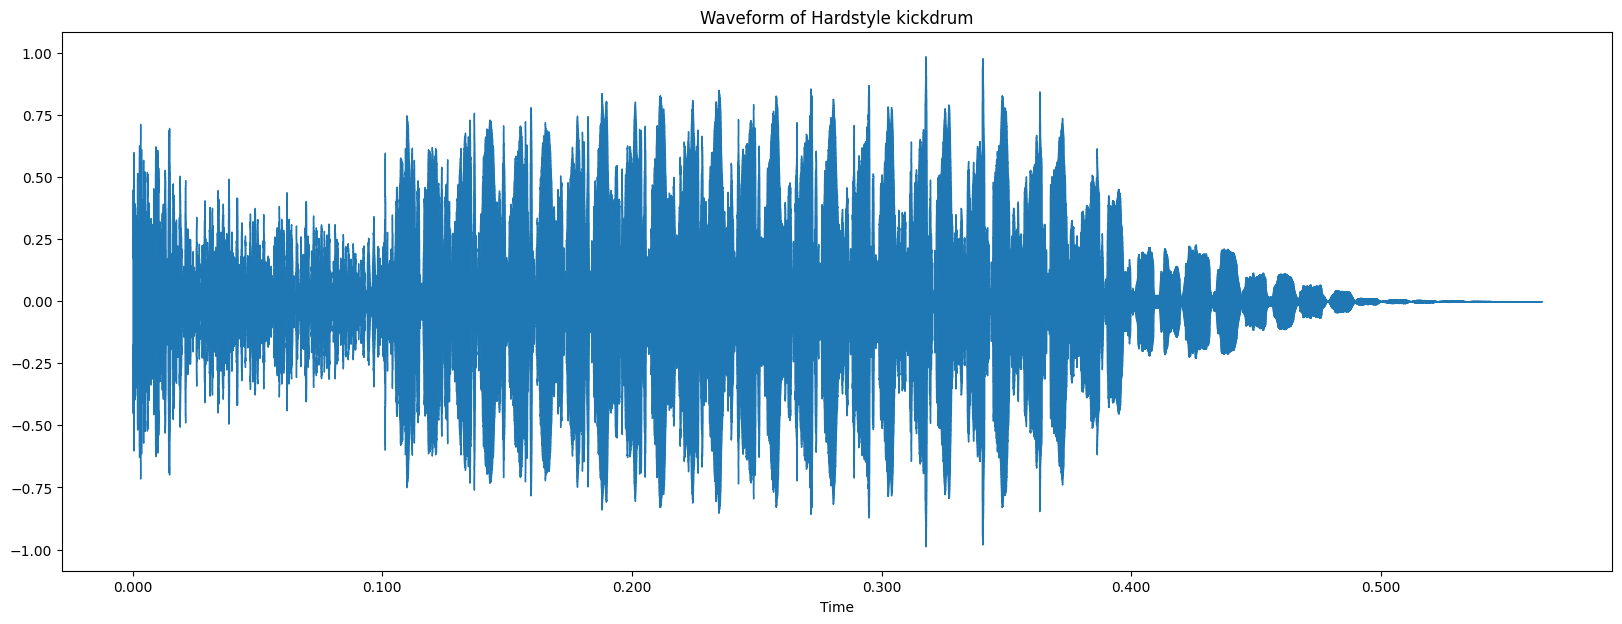

In [ ]:
demo = librosa.load('/content/drive/MyDrive/audio_samples/Analog_Kicks/Bloodfire - RW Kick7 F.wav', sr = 44100, mono = True)
audio_data = demo[0]
demo_sample_rate = demo[1]
plt.figure(figsize=(20,7))
librosa.display.waveshow(audio_data, sr = 44100)
plt.title(f"Waveform of Hardstyle kickdrum")
plt.show()
display(Audio(audio_data, rate=demo_sample_rate))

## Loader for MNIST
When creating the encoder i first used MNIST data set that consisted of mono-colors numbers to create the initial build. After that i started to create the spectrograms and adjust the model.  

In [ ]:
# #loading dataset
# transform = transforms.ToTensor()

# train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
# train_data.shape
# # test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [ ]:
# # #train_loader = DataLoader(train_data, batch_size=10, shuffle=True) #original
# # #updated loaders with smaller train/test sets
#train_loader = DataLoader(torch.utils.data.Subset(train_data, range(5000)), batch_size=25, shuffle=True)
# # test_loader = DataLoader(torch.utils.data.Subset(train_data, range(5000, 12000)), batch_size=25, shuffle=False)
#train_loader.shape

# Data display class
This section contains a class used for displaying data in a spectragram and 2D represenation of the total amplitude vs time.

In [ ]:
class data_display():
  def __init__(self, data_source, sample_rate, hop_length,  scaler=None):
    self.data_source = data_source
    self.sample_rate = sample_rate
    self. hop_length = hop_length
    self.scaler = scaler


  def set_figsize(self, size="medium"):
    if size == "small":
      self.figsize =(4,3)
    elif size == "medium":
      self.figsize = (8,6)
    elif size == "large":
      self.figsize = (16,12)
    else:
      raiseValueError("invalid size. Please choose small, meduim, or large")


  def display_waveform(self):
    plt.figure(figsize=self.figsize)
    plt.grid(True)
    # Detach the tensor from the computation graph before plotting
    if isinstance(self.data_source, torch.Tensor):
      # Detach the tensor before converting to NumPy if it requires grad
      if self.data_source.requires_grad:
          data_to_plot = self.data_source[0, :, 0].detach().cpu().numpy()
      else:
          data_to_plot = self.data_source[0, :, 0].cpu().numpy()
    else:
        data_to_plot = self.data_source[0, :, 0]  # Assume NumPy array or similar
    plt.plot(data_to_plot, label=f'data{i}')
    plt.ylabel("Amplitude")
    plt.title("Waveform")
    plt.legend()

  def display_spectrogram(self):
    plt.figure(figsize=self.figsize)
    self.reshaped_data = self.data_source[:, :, :].squeeze()
    print(self.reshaped_data.shape)
    # Check if self.reshaped_data is a PyTorch tensor
    if isinstance(self.reshaped_data, torch.Tensor):
        # Convert to NumPy array if it's a tensor
        self.reshaped_data = self.reshaped_data.cpu().detach().numpy()
    # Apply inverse transform to denormalize if scaler is provided
    if self.scaler is not None:
        self.reshaped_data = self.scaler.inverse_transform(self.reshaped_data)
        # min_val, max_val = self.scaler  # Get min-max values
        # self.reshaped_data = self.reshaped_data * (max_val - min_val) + min_val  # Denormalize
    plt.axis("off")
    #spectrogram = librosa.amplitude_to_db(np.abs(self.reshaped_data), ref=np.max)
    img = librosa.display.specshow(self.reshaped_data, sr=self.sample_rate,hop_length=self.hop_length, x_axis='time', y_axis='log', cmap="magma")
    plt.title("Spectrogram")
    #plt.xlabel(f'Dimension length: {len(data[0,:,0])}')
    #plt.colorbar(img, ax=ax2, format="%+2.0f dB")  # Add colorbar to spectrogram
    plt.show()


# Implementing audio preprocesessing.

This section contains the class I use to process the sound files and convert them into spectrograms. Padding is applied where needed to ensure all the samples are the same length when fed into the autoencoder. I also use Librosa to remove higher-frequency harmonics. This removes most of the initial transient, which provides no tone, and allows the encoder to concentrate on the lower frequencies that contain most of the kick's tonal data. I also experimented with shifting the pitch of each sample by one semitone (a common practice in music production) to expand the library, but this ultimately led to worse results."

"Note: I only used a dataset of 412 kicks because I wanted to use only free-use samples without copyright restrictions. This data comes from posts on the r/Hardstyle subreddit.

In [ ]:
class PreprocessingPipeline:
  def __init__(self, SPECTROGRAMS_SAVE_DIR, FILES_DIR, SAMPLE_RATE, DURATION, MONO, FRAME_SIZE, HOP_LENGTH):
    self.file_path = FILES_DIR
    self.mono = MONO
    self.save_path = SPECTROGRAMS_SAVE_DIR
    self.sample_rate = SAMPLE_RATE
    self.duration = DURATION
    self.frame_size =  FRAME_SIZE
    self.hop_length = HOP_LENGTH
    self.num_expected_sample = int(self.sample_rate * self.duration)

  def _file_load(self, file_path):
    signal = librosa.load(file_path, sr = self.sample_rate, duration=self.duration, mono= self.mono)[0]
    return signal

  def _apply_padding(self, signal):
    num_missing_samples = self.num_expected_sample - len(signal)
    print(f"number of missing samples {num_missing_samples}")
    padded_signal = np.pad(signal, (0, num_missing_samples),mode="constant")
    print(f"new padded shape {padded_signal.shape}")
    return padded_signal

  def _extract_harmonics(self, signal):
    harmonic = librosa.effects.harmonic(signal, margin=4.0)
    #_harmonic, _transient = librosa.effects.hpss(signal, margin=(3.0, 7.0))
    return harmonic

  def _augment_audio(self, signal):
    n_steps = np.random.randint(-1, 1)
    augmented_audio = librosa.effects.pitch_shift(signal, sr=self.sample_rate, n_steps=n_steps)
    return augmented_audio

  def _extract(self,signal):
    #n_fft = min(self.frame_size, len(signal))
    stft = librosa.stft(signal,n_fft=self.frame_size,hop_length=self.hop_length)[:-1]
    spectrogram = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    return log_spectrogram

  def _save_feature(self, feature, file_path, count):
    save_path = self._generate_save_path(file_path, count)
    np.save(save_path, feature)

  def _save(self, data, save_path):
    with open(save_path, "wb") as f:
      pickle.dump(data, f)

  def _generate_save_path(self,file_path, count):
    file_name = os.path.split(file_path)[1]
    save_path = os.path.join(self.save_path, file_name + ".npy")
    print(f"Saved: {self.save_path, file_name + str(count)}.npy")
    return save_path

  def process(self,audio_file_dir):
    file_count = 0
    for root, _, files in os.walk(audio_file_dir):
      for file in files:
        file_path = os.path.join(root, file)
        self._process_file(file_path)
        # if file_count < 5:
        #   signal = self.file_load(file_path)
        #   plt.figure(figsize=(20,7))
        #   librosa.display.waveshow(signal, sr = self.sample_rate)
        #   plt.title(f"Waveform of {file}")
        #   plt.show()
        #   file_count += 1
        #print(f"Processed file {file_path}")
    #self.saver.save_min_max_values(self.min_max_values)
    print("Files complete")

  def _process_file(self, file_path):
    signal = self._file_load(file_path)
    print(f"Shape before padding {signal.shape}")
    if len(signal) < self.num_expected_sample:
      signal = self._apply_padding(signal)
    else: print("No padding needed")
    pitch_count = 0
    # while pitch_count < 2:
    #   pitched_audio = self.augment_audio(signal)
    harmonic_signal = self._extract_harmonics(signal)
    feature = self._extract(harmonic_signal)
    self._save_feature(feature, file_path, pitch_count)
    #   pitch_count += 1

Setting hyperparameters for preprocessing

In [ ]:
  frame_size = 4096
  hop_length = 1024
  duration = 0.9  # in seconds
  sample_rate = 44100 #SR for kicks
  mono = True

  spectrograms_save_dir = "/content/drive/MyDrive/audio_samples/Kick_spectrograms"
  file_dir = "/content/drive/MyDrive/audio_samples/Analog_Kicks"

  preprocessing_pipeline = PreprocessingPipeline(spectrograms_save_dir, file_dir, sample_rate, duration, mono, frame_size, hop_length)
  #preprocessing_pipeline.process(file_dir)

# Loading processed spectrograms into a data set

In [ ]:
def load_spectrograms(spectrograms_path):
  _data_pool = []
  file_paths = []
  for root, _, file_names in os.walk(spectrograms_save_dir):
    for file_name in file_names:
      file_path = os.path.join(root, file_name)
      spectrogram = np.load(file_path)
      file_paths.append(file_path)
      _data_pool.append(spectrogram)
  _data_pool = np.array(_data_pool)
  #print(x_train.shape)
  _data_pool = _data_pool[:, np.newaxis, ...] #creating a new axis for channel
  print(f"data pool Shape:{_data_pool.shape}")
  return _data_pool, file_paths

data_pool, file_paths = load_spectrograms(spectrograms_save_dir)
print(f"Data pool max/min {data_pool.max(), data_pool.min()}")

data pool Shape:(412, 1, 2048, 39)
Data pool max/min (np.float32(61.495445), np.float32(-41.72722))


# Displaying of initial spectrograms before normalization

255
(2048, 39)


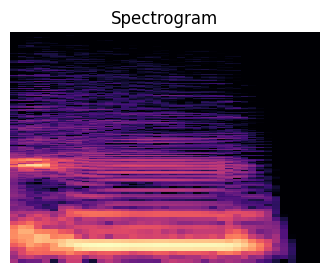

/content/drive/MyDrive/audio_samples/Kick_spectrograms/Bloodfire - RW Kick3 E.wav.npy
Max is 51.70550537109375, Min is -28.29449462890625
362
(2048, 39)


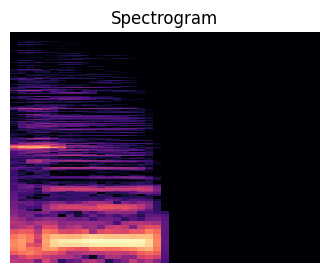

/content/drive/MyDrive/audio_samples/Kick_spectrograms/Sabotage - 6.wav.npy
Max is 59.649253845214844, Min is -20.350746154785156
261
(2048, 39)


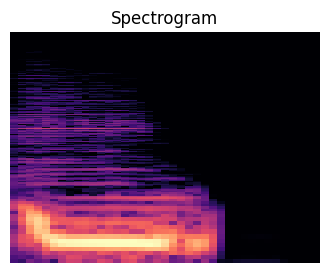

/content/drive/MyDrive/audio_samples/Kick_spectrograms/Demolite - Reversi 3 G.wav.npy
Max is 50.47510528564453, Min is -29.52489471435547


In [ ]:
import librosa.display
import random
for i in range(3):
  random_integer = random.randint(1,len(data_pool) -1)
  print(random_integer)
  data = data_pool[random_integer]

  original_image = data_display(data, sample_rate, hop_length, scaler=None)
      #original_image.display_waveform()
  original_image.set_figsize("small")
  original_image.display_spectrogram()
  # Create a figure and axes for the plots

  plt.show()
  print(file_paths[random_integer])
  print(f"Max is {data.max()}, Min is {data.min()}")

In [ ]:
original_spectrogram_values = []

for values in data_pool:
  min_val = values.min()
  max_val = values.max()
  original_spectrogram_values.append((min_val, max_val))
#print(original_spectrogram_values)


[(np.float32(-23.148651), np.float32(56.85135)), (np.float32(-21.436653), np.float32(58.563347)), (np.float32(-26.175343), np.float32(53.824657)), (np.float32(-24.519531), np.float32(55.48047)), (np.float32(-22.553818), np.float32(57.446182)), (np.float32(-21.649132), np.float32(58.35087)), (np.float32(-22.792591), np.float32(57.20741)), (np.float32(-20.58841), np.float32(59.41159)), (np.float32(-23.261337), np.float32(56.738663)), (np.float32(-20.064922), np.float32(59.935078)), (np.float32(-21.34298), np.float32(58.65702)), (np.float32(-20.912384), np.float32(59.087616)), (np.float32(-20.728588), np.float32(59.27141)), (np.float32(-23.799484), np.float32(56.200516)), (np.float32(-20.40527), np.float32(59.59473)), (np.float32(-21.441093), np.float32(58.558907)), (np.float32(-19.861748), np.float32(60.138252)), (np.float32(-20.71283), np.float32(59.28717)), (np.float32(-21.598354), np.float32(58.401646)), (np.float32(-21.561047), np.float32(58.438953)), (np.float32(-20.301987), np.floa

# Applying normalization

In many cases, data is normalized to be between 0 and 1. I chose to experiment with a -1 to 1 normalization because the spectrogram data's range included both negative and positive numbers. I was surprised to see better results using this approach. This, in turn, required the use of LeakyReLU and Tanh activation functions to preserve negative values during encoding.


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1), clip=True)
# Normalize along the frequency and time dimensions (axes 2 and 3)
num_samples = data_pool.shape[0]
normalized_data_pool = np.zeros_like(data_pool, dtype=np.float32)
for i in range(num_samples):
    normalized_data_pool[i, 0] = scaler.fit_transform(data_pool[i, 0])
    # Applying fit_transform to each sample individually

print(normalized_data_pool.max())
print(normalized_data_pool.min())
print(f"Shape: {normalized_data_pool.shape}")
#print(normalized_data_pool[0])

1.0
-1.0
Shape: (412, 1, 2048, 39)


# Creating Autoencoder

The power of variational autoencoders lies in their use of probability distributions in the latent space, rather than simple vectors. During training, the latent space is tuned by shifting it closer to a Gaussian distribution with each epoch. This allows for the generation of new and unique-sounding samples when novel spectrograms are passed through the trained encoder. To mitigate overfitting, dropout layers were added to the initial layers. Early stopping and a failsafe mechanism triggered by a significant spike in the KL-loss regularizer were also implemented. Finally, the placement of batch normalization was adjusted to determine whether positioning it before or after the LeakyReLU activation function yielded superior results.

In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self,input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim, padding, output_padding, device):
    super().__init__()
    self.input_shape = input_shape
    self.conv_filters = conv_filters
    self.conv_kernels = conv_kernels
    self.conv_strides = conv_strides
    self.latent_space_dim = latent_space_dim
    self.padding = padding
    self.output_padding = output_padding
    self.device = device


  #build initial model
  def build_model(self):
    self.encoder = self._build_encoder()

    #Create test input to get bottleneck and decoder shapes
    test_input = torch.randn(1, *self.input_shape)
    with torch.no_grad():
        test_output = self.encoder(test_input)
    self.shape_before_bottleneck = test_output.shape
    print(f"Shape before bottleneck is {self.shape_before_bottleneck}")
    self.encoder_output_size_flattened = torch.prod(torch.tensor(self.shape_before_bottleneck)).item()

    #build latent space and decoder
    self.mu, self.log_variance = self._build_latent_space()
    self.decoder = self._build_decoder()

    # Move the model components to the specified device
    self.to(device)


  def _build_encoder(self):
    encoder = nn.Sequential(
        nn.Conv2d(input_shape[0], conv_filters[0], kernel_size=conv_kernels[0], stride=conv_strides[0], padding=1),
        nn.LeakyReLU(),
        nn.Dropout(0.05),
        nn.BatchNorm2d(num_features=conv_filters[0]),
        nn.Conv2d(conv_filters[0], conv_filters[1], kernel_size=conv_kernels[1], stride=conv_strides[1], padding=1),
        nn.LeakyReLU(),
        nn.Dropout(0.05),
        nn.BatchNorm2d(num_features=conv_filters[1]),
        nn.Conv2d(conv_filters[1], conv_filters[2], kernel_size=conv_kernels[2], stride=conv_strides[2], padding=1),
        nn.LeakyReLU(),
        nn.Dropout(0.05),
        nn.BatchNorm2d(num_features=conv_filters[2]),
        nn.Conv2d(conv_filters[2], conv_filters[3], conv_kernels[3], stride=conv_strides[3], padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(num_features=conv_filters[3]),
        nn.Dropout(0.05),
        nn.Conv2d(conv_filters[3], conv_filters[4], conv_kernels[4], stride=conv_strides[4], padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(num_features=conv_filters[4]),
    )
    return encoder

  def _build_decoder(self):
    decoder = torch.nn.Sequential(
        nn.Linear(latent_space_dim, self.encoder_output_size_flattened),
        nn.LeakyReLU(),
        nn.Unflatten(1, self.shape_before_bottleneck[1:]),
        nn.Dropout(0.05),
        nn.ConvTranspose2d(conv_filters[4], conv_filters[4], kernel_size=conv_kernels[4], stride=conv_strides[4], padding=padding[0], output_padding=output_padding[0]),
        nn.LeakyReLU(),
        nn.BatchNorm2d(num_features=conv_filters[4]),
        nn.ConvTranspose2d(conv_filters[4], conv_filters[3], kernel_size=conv_kernels[3], stride=conv_strides[3], padding=padding[1], output_padding=output_padding[1]),
        nn.LeakyReLU(),
        nn.BatchNorm2d(num_features=conv_filters[3]),
        nn.ConvTranspose2d(conv_filters[3], conv_filters[2], kernel_size=conv_kernels[2], stride=conv_strides[2], padding=padding[2], output_padding=output_padding[2]),
        nn.LeakyReLU(),
        nn.BatchNorm2d(num_features=conv_filters[2]),
        nn.ConvTranspose2d(conv_filters[2], conv_filters[1], kernel_size=conv_kernels[1], stride=conv_strides[1], padding=padding[3], output_padding=output_padding[3]),
        nn.LeakyReLU(),
        nn.BatchNorm2d(num_features=conv_filters[1]),
        nn.ConvTranspose2d(conv_filters[1], 1, kernel_size=(conv_kernels[0]), stride=conv_strides[0], padding=padding[4], output_padding=output_padding[4]),
        nn.Tanh()  # Output in range [-1, 1]
    )
    return decoder

  def _build_latent_space(self):
    mu = nn.Linear(self.encoder_output_size_flattened, latent_space_dim)  # Define mu layer
    log_variance = nn.Linear(self.encoder_output_size_flattened, latent_space_dim)  # Define logvar layer
    return mu, log_variance

  #Run data through latent space
  def bottleneck(self, X):
    X = torch.flatten(X, start_dim=1)
    self.mu_tensor = self.mu(X)  # Use the defined mu layer
    self.log_variance_tensor = self.log_variance(X)  # Use the defined logvar layer
    epsilon = torch.randn_like(self.log_variance_tensor).to(device) #Sample point in the latent space
    return self.mu_tensor + torch.exp(0.5 * self.log_variance_tensor) * epsilon

  #calculate KL Loss
  def KL_divergence(self):
    return -0.5 * torch.sum(1 + self.log_variance_tensor - self.mu_tensor.pow(2) - torch.exp(self.log_variance_tensor), dim=1)

  #main forward method
  def forward(self, input):
    encoded = self.encoder(input)
    bottleneck = self.bottleneck(encoded)
    decoded = self.decoder(bottleneck)
    return decoded

  #Reconstruction method for testing
  def reconstruct(self, images):
    encoded_image = self.encoder(images)
    latent_representations = self.bottleneck(encoded_image.to(self.device))
    reconstructed_images = self.decoder(latent_representations)
    return reconstructed_images, latent_representations



## Train the model
Creating class that will handle model training.

In [ ]:
class model_trainer():
  def __init__(self, train_loader, val_loader, epochs, KL_weight, patience, criterion, optimizer, model, save_path):
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.epochs = epochs
    self.KL_weight = KL_weight
    self.patience = patience
    self.criterion = criterion
    self.optimizer = optimizer
    self.train_losses = []
    self.val_losses = []
    self.KL_losses = []
    self.train_correct = []
    self.test_correct = []
    self.best_test_loss = float("inf")
    self.epochs_without_improvement = 0
    self.model = model
    self.start_time = time.time()
    self.save_path = save_path
    self.kl_loss_spike = False

  def train(self):
    for i in range(self.epochs):
      # Run the training batches
      for b, data in enumerate(train_loader):
        b+=1

        X_train = data
        # Move X_train to the appropriate device
        X_train = X_train.to(device)

        # Apply the model
        y_pred = model(X_train)

        #caculate MSE_loss
        loss = criterion(y_pred, X_train)

        # KL_divergence loss
        KL_loss = model.KL_divergence()
        KL_loss = KL_loss.mean()
        self.KL_losses.append(KL_loss.item())

        # Print interim results
        if b%3 == 0:
            print(f'epoch: {i+1:2}  batch: {b:4} [{b* train_loader.batch_size:6}/{len(train_loader.dataset)}]  loss: {loss.item():10.8f}, KL-loss = {KL_loss:10.8f}')

        #calculate KL_loss
        loss =  loss + (KL_weight * (i+1)) * KL_loss #added KL annealing so the Network minimizes MSE loss before KL loss
        if i > 9 and KL_loss > 100:
          self.kl_loss_spike = True
          break

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.cuda.empty_cache() #empty cache due to memory issues in Collab


      self.train_losses.append(loss.item())
      print(f'Training loss at Epoch {i+1} is {self.train_losses[-1]}')

      if self.kl_loss_spike:
        print(f"KL spike detected at {epochs}")
        torch.save(self.model.state.dict(), self.save_path)
        break
      # Runing validation batches
      with torch.no_grad():
        for b, X_test in enumerate(val_loader):
          X_test = X_test.to(device)
          y_val = model(X_test)
          val_loss = criterion(y_val, X_test)
          KL_loss = model.KL_divergence()
          KL_loss = KL_loss.mean()
          val_loss =  val_loss + (KL_weight * (i+1)) * KL_loss

      self.val_losses.append(val_loss.item())
      print(f'Validation loss at Epoch {i+1} is {self.val_losses[-1]}')

      elasped_time = time.time() - self.start_time
      print(f"Elasped time is {elasped_time: .0f} seconds.\n")
      #Early stopping check


      if self.train_losses[-1] < self.best_test_loss:
        self.best_test_loss = self.train_losses[-1]
        epochs_without_improvement = 0
      else:
        self.epochs_without_improvement += 1
        if self.epochs_without_improvement >= self.patience:
          print(f"Early stopping at epoch {i+1}")
          torch.save(self.model.state_dict(), self.save_path)
          print(f"Model saved to {self.save_path}")
          break

    print(f'\nDuration: {time.time() - self.start_time:.0f} seconds') # print the time elapsed

  #Retrun loss data for graphing
  def return_losses(self):
    return self.train_losses, self.val_losses


# Training/ Test batch declaration

In [ ]:
train_loader = DataLoader(torch.utils.data.Subset(normalized_data_pool, range(375)), batch_size=20, shuffle=True)
val_loader = DataLoader(torch.utils.data.Subset(normalized_data_pool, range(386, 400)), batch_size=5, shuffle=False)
test_loader = DataLoader(torch.utils.data.Subset(normalized_data_pool, range(401, 412)), batch_size=4, shuffle=False)
test_min_max_values = original_spectrogram_values[401:413]
print(test_min_max_values)

[(np.float32(-25.844902), np.float32(54.155098)), (np.float32(-23.098885), np.float32(56.901115)), (np.float32(-33.315834), np.float32(46.684166)), (np.float32(-26.704746), np.float32(53.295254)), (np.float32(-27.700329), np.float32(52.29967)), (np.float32(-22.247246), np.float32(57.752754)), (np.float32(-20.372623), np.float32(59.627377)), (np.float32(-26.479942), np.float32(53.520058)), (np.float32(-22.241043), np.float32(57.758957)), (np.float32(-23.142426), np.float32(56.857574)), (np.float32(-29.035244), np.float32(50.964756))]


# Training parameters and Initialization

In [ ]:
#memory management when using limited GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"

# #deletes any previous models that have been initialize. This is to help free up GPU. Otherwise when I try to intialize with new parameters I will get an error
if 'model' in locals():
  del model
  torch.cuda.empty_cache()

torch.manual_seed(42)
input_shape= normalized_data_pool.shape[1:]
conv_filters=(1024, 512, 256, 128, 64)
conv_kernels=(3, 3, 3, 3, 3)
conv_strides=(2, 2, 2, 2, (2,1))
padding = (1,1,1,1,1)
output_padding = ((1,0),(1,0),(1,1),(1,1),(1,0)) #padding for decoder output to match input.
latent_space_dim= 2048
epochs = 100
KL_weight = .0008
patience = 15 #Patience level for early stopping


save_path= "/content/drive/MyDrive/my_model.pth"

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Current input shape is {input_shape}")



model = ConvolutionalNetwork(input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim, padding, output_padding, device)
model.build_model()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

#run model summary to check parameters
summary(model, input_size=input_shape)


Current input shape is (1, 2048, 39)
Shape before bottleneck is torch.Size([1, 64, 64, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 1024, 1024, 20]          10,240
         LeakyReLU-2       [-1, 1024, 1024, 20]               0
           Dropout-3       [-1, 1024, 1024, 20]               0
       BatchNorm2d-4       [-1, 1024, 1024, 20]           2,048
            Conv2d-5         [-1, 512, 512, 10]       4,719,104
         LeakyReLU-6         [-1, 512, 512, 10]               0
           Dropout-7         [-1, 512, 512, 10]               0
       BatchNorm2d-8         [-1, 512, 512, 10]           1,024
            Conv2d-9          [-1, 256, 256, 5]       1,179,904
        LeakyReLU-10          [-1, 256, 256, 5]               0
          Dropout-11          [-1, 256, 256, 5]               0
      BatchNorm2d-12          [-1, 256, 256, 5]             512
           C

# Declare and initiate training

In [ ]:
train_model = model_trainer(train_loader, val_loader, epochs, KL_weight, patience, criterion, optimizer, model, save_path)
train_model.train()

epoch:  1  batch:    3 [    60/375]  loss: 1.56754768, KL-loss = 426.39450073
epoch:  1  batch:    6 [   120/375]  loss: 1.03430176, KL-loss = 238.02871704
epoch:  1  batch:    9 [   180/375]  loss: 0.68375909, KL-loss = 144.58915710
epoch:  1  batch:   12 [   240/375]  loss: 0.49053848, KL-loss = 111.77508545
epoch:  1  batch:   15 [   300/375]  loss: 0.29995266, KL-loss = 146.42366028
epoch:  1  batch:   18 [   360/375]  loss: 0.23084342, KL-loss = 104.68868256
Training loss at Epoch 1 is 0.2797643542289734
Validation loss at Epoch 1 is 0.281572163105011
Elasped time is  31 seconds.

epoch:  2  batch:    3 [    60/375]  loss: 0.21025744, KL-loss = 39.41877365
epoch:  2  batch:    6 [   120/375]  loss: 0.16267918, KL-loss = 35.36134720
epoch:  2  batch:    9 [   180/375]  loss: 0.12497054, KL-loss = 46.25032425
epoch:  2  batch:   12 [   240/375]  loss: 0.11769177, KL-loss = 37.08637238
epoch:  2  batch:   15 [   300/375]  loss: 0.11089786, KL-loss = 28.72670937
epoch:  2  batch:   18

## Plot the loss and accuracy comparisons
Simple comparison of testing and validation loss over epochs

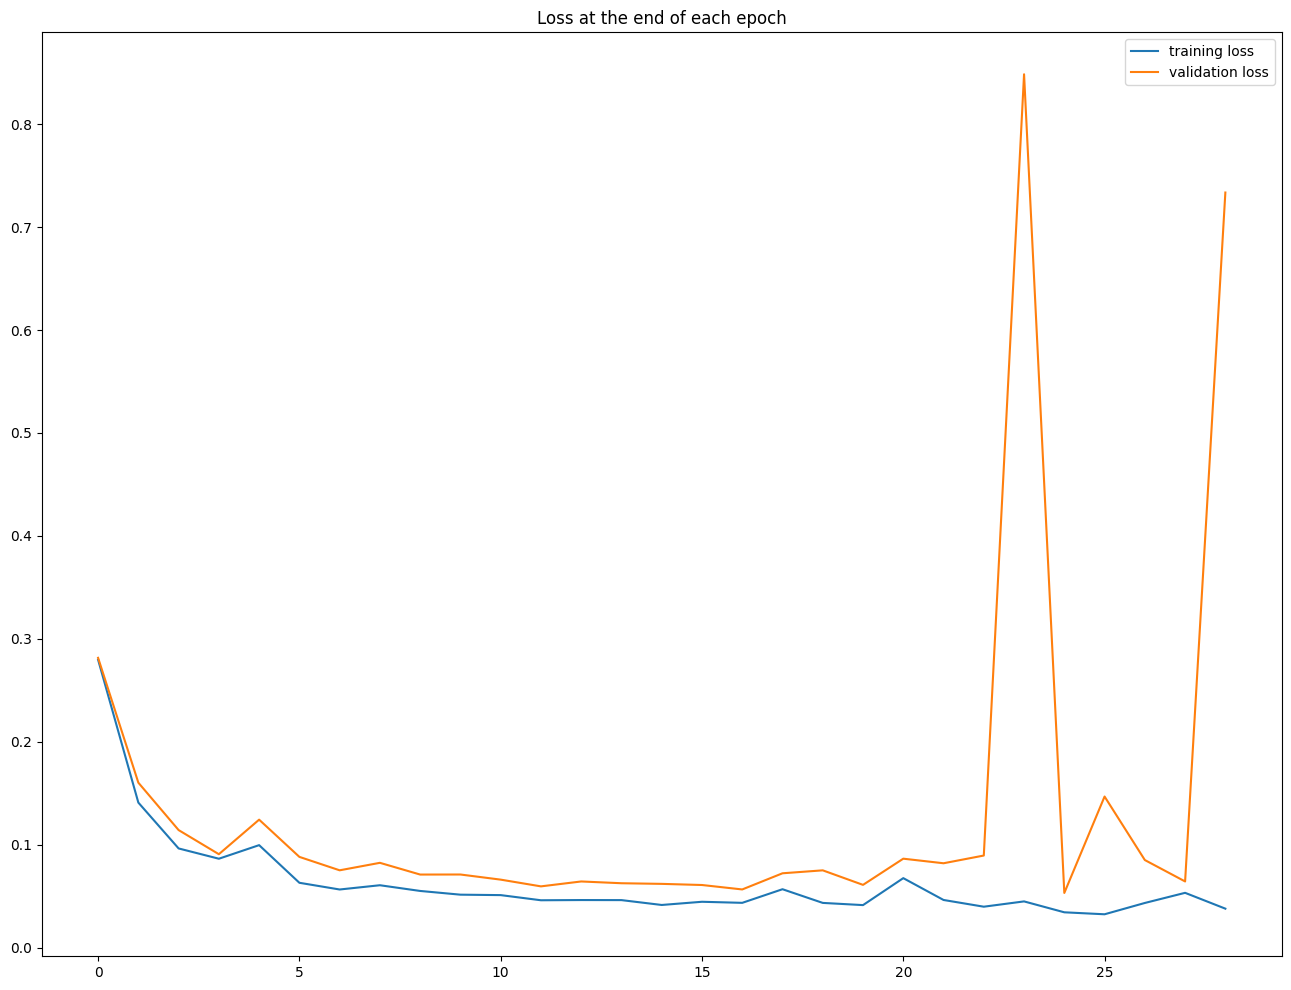

In [ ]:
train_losses, val_losses = train_model.return_losses()
plt.figure(figsize=(16, 12))
plt.plot(train_losses[:-1], label='training loss')
plt.plot(val_losses [:-1], label='validation loss')
#plt.plot(KL_losses, label='KL loss')
plt.title('Loss at the end of each epoch')
plt.legend();

# Testing function declarations


In [ ]:


def select_images(loader, num_images= 4, min_max_values=None):
    image_index = np.random.choice(len(loader.dataset), size=num_images, replace=False)
    sample_images = []
    sample_min_max =[]
    for index in image_index:
        sample_images.append(torch.from_numpy(loader.dataset[index]))
        if min_max_values is not None:
            sample_min_max.append(min_max_values[index])
            print(sample_min_max[-1])  # Print the value that was appended
    sample_images = torch.stack(sample_images)
    return sample_images, sample_min_max

def plot_reconstructed_images(images, reconstructed_images, min_max_values):
  num_images = len(images)
  fig, axes = plt.subplots(num_images, 2, figsize=(12, 6 * num_images), sharex='col')  # Create subplots

  for i, (image, reconstructed_image) in enumerate(zip(images, reconstructed_images)):
    # Extract and potentially denormalize spectrogram data
    original_spectrogram = image[0, :, :].cpu().detach().numpy().squeeze()
    reconstructed_spectrogram = reconstructed_image[0, :, :].cpu().detach().numpy().squeeze()
    if scaler is not None:
        original_spectrogram = scaler.inverse_transform(original_spectrogram)
        reconstructed_spectrogram = scaler.inverse_transform(reconstructed_spectrogram)

    # Plot on the appropriate subplot axes:
    librosa.display.specshow(original_spectrogram, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log', cmap="magma", ax=axes[i, 0])
    axes[i, 0].set_title("Original Spectrogram")

    librosa.display.specshow(reconstructed_spectrogram, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log', cmap="magma", ax=axes[i, 1])
    axes[i, 1].set_title("Reconstructed Spectrogram")


def Latent_space_plot(latent_representation, sample_labels):
    plt.figure(figsize=(10,10))
    plt.scatter(latent_representation[:,0],
      latent_representation[:,1],
      #cmap="viridis",
      #c = sample_labels,
      alpha=.5,
      s=2)
    plt.colorbar()
    plt.show()


def convert_spectrograms_to_audio(sample_images, reconstructed_images, scaler):
    original_signals = []
    reconstructed_signals= []
    if reconstructed_images is not None and len(reconstructed_images) > 0:
      for spectrogram in reconstructed_images:
          log_spectrogram = spectrogram[0,:, :].cpu().detach().numpy().squeeze()
          denormalized_spectrogram = scaler.inverse_transform(log_spectrogram)
          print(f"Max is {denormalized_spectrogram.max()}, Min is {denormalized_spectrogram.min()}")
          spec = librosa.db_to_amplitude(denormalized_spectrogram)
          signal = librosa.istft(spec, hop_length=hop_length)
          reconstructed_signals.append(signal)
    for spectrogram in sample_images:
        log_spectrogram = spectrogram[0,:, :].cpu().detach().numpy().squeeze()
        denormalized_spectrogram = scaler.inverse_transform(log_spectrogram)
        print(f"Max is {denormalized_spectrogram.max()}, Min is {denormalized_spectrogram.min()}")
        spec = librosa.db_to_amplitude(denormalized_spectrogram)
        signal = librosa.istft(spec, hop_length=hop_length)
        original_signals.append(signal)

    for i in range(len(original_signals)):
        print(f"Audio Pair {i + 1}")
        display(Audio(original_signals[i], rate=sample_rate))  # Display original
        display(Audio(reconstructed_signals[i], rate=sample_rate))  # Display reconstructed

    return original_signals, reconstructed_signals

# Re-loading model for eval purposes

In [ ]:
eval_model = ConvolutionalNetwork(input_shape, conv_filters, conv_kernels, conv_strides, latent_space_dim, padding, output_padding, device)
eval_model.build_model()
eval_model.load_state_dict(torch.load(save_path))
eval_model.to(device)
eval_model.eval()

Shape before bottleneck is torch.Size([1, 64, 64, 3])


ConvolutionalNetwork(
  (encoder): Sequential(
    (0): Conv2d(1, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.05, inplace=False)
    (3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.05, inplace=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Dropout(p=0.05, inplace=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.01)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

#Run testing functions

While I am happy with the results, I do feel that my encoder is not currently able to capture the specific tonal uniqueness of my original spectrograms. The latent space has captured what is common between each sample and recreated that. I feel the biggest improvement I could make is simply to have more data to use during training.

(np.float32(-36.46705), np.float32(43.53295))
(np.float32(-20.02161), np.float32(59.97839))
(np.float32(-27.677784), np.float32(52.322216))
(np.float32(-20.235176), np.float32(59.764824))
Max is 50.96475601196289, Min is -29.035234451293945
Max is 50.964744567871094, Min is -29.03524398803711
Max is 50.96475601196289, Min is -29.035228729248047
Max is 50.773990631103516, Min is -29.035245895385742
Max is 50.96475601196289, Min is -29.035245895385742
Max is 50.964752197265625, Min is -29.035245895385742
Max is 50.96475601196289, Min is -29.035245895385742
Max is 50.96475601196289, Min is -29.035245895385742
Audio Pair 1


Audio Pair 2


Audio Pair 3


Audio Pair 4


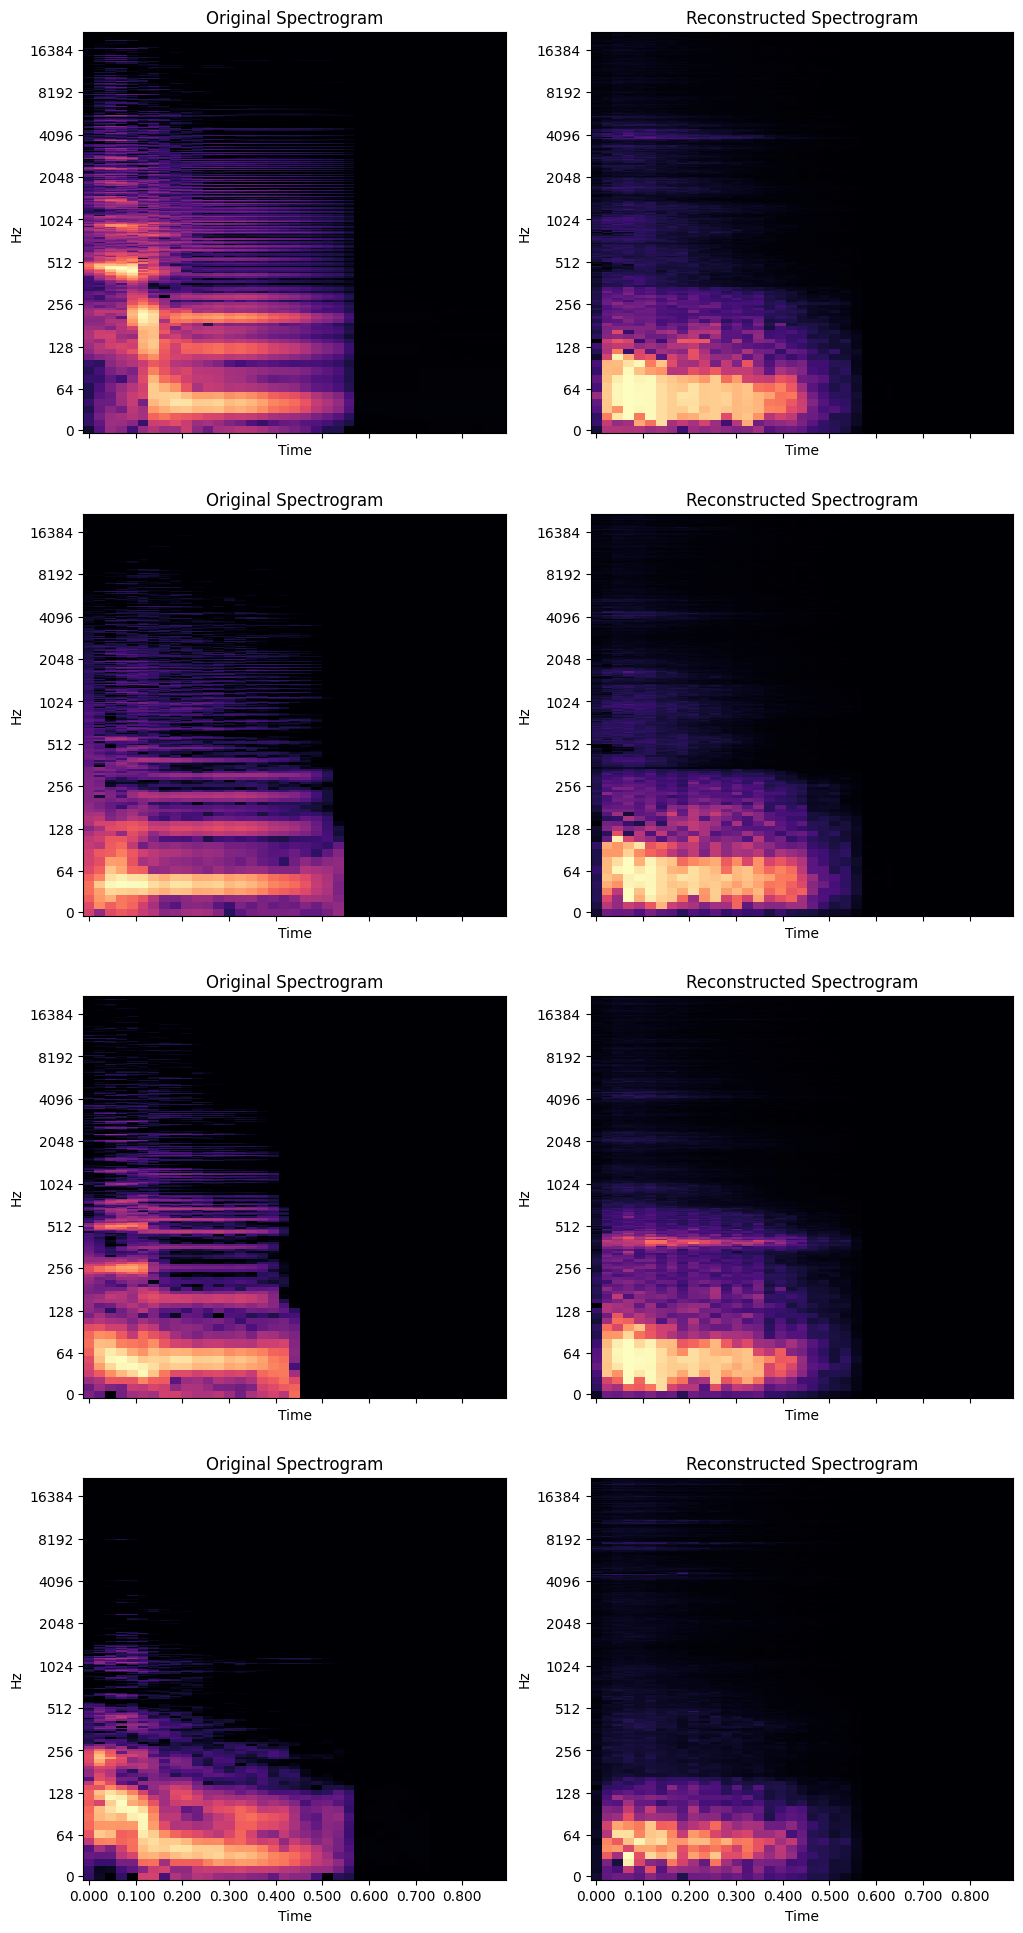

In [ ]:
num_samples = 4
model.eval()

train_min_max_values = original_spectrogram_values[:375]
sample_images, min_max_values = select_images(train_loader, num_samples, min_max_values=train_min_max_values)
sample_images = sample_images.to(device)
reconstructed_images, latent_repesentation = eval_model.reconstruct(sample_images)
plot_reconstructed_images(sample_images.cpu(), reconstructed_images.cpu(), min_max_values)
original_audio, reconstructed_audio = convert_spectrograms_to_audio(sample_images, reconstructed_images, scaler)
# Audio(original_audio[0], rate=SAMPLE_RATE)
# Audio(reconstructed_audio[0], rate=SAMPLE_RATE)